## Uploading and Filtering the Circuitscape Map

This notebook will allow you to upload the circuitscape map that will be used to determine dipsersal. Values that fall outside of the current density range will be filtered to aid in visualization. The resulting numpy array will be saved as a .tif file to be imported for the notebook #2.

In [59]:
# MatPlotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pylab
from matplotlib.colors import LinearSegmentedColormap

# Scientific libraries
import numpy as np

# Spatial Analyses
from osgeo import gdal

# Circuitscape Map
deer = '/Users/meredithvanacker/PDSB/PDSB-Project/data/circuit_tenm.asc'

Open the raster file

In [60]:
dataset = gdal.Open(deer)
if dataset is None:
    print('Could not open image')
    sys.exit(1)
dataset

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x13a2c4720> >

Define rows and columns from raster.

In [61]:
cols = dataset.RasterXSize
rows = dataset.RasterYSize
bands = dataset.RasterCount
driver = dataset.GetDriver().LongName

In [62]:
cols 

1734

In [63]:
rows

1702

In [64]:
bands

1

In [65]:
driver

'Arc/Info ASCII Grid'

Check the data type of raster.

In [66]:
band = dataset.GetRasterBand(1)
bandtype = gdal.GetDataTypeName(band.DataType)
bandtype

'Float32'

### Begin visualizing the data.

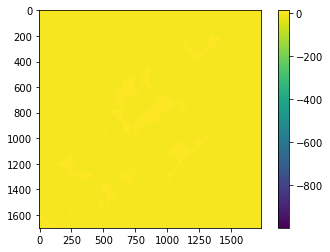

In [67]:
pixel_values = dataset.ReadAsArray()
plt.imshow(pixel_values)
plt.colorbar()

### Find and filter No Data values.

In [68]:
# What values are set for no data?
pixel_values.min()

-999.0

In [69]:
pixel_values.max()

12.648996

In [70]:
# Get rid of negative values by taking the absolute value
p = np.absolute(pixel_values)
p

array([[999., 999.,   0., ...,   0.,   0.,   0.],
       [999., 999.,   0., ...,   0.,   0.,   0.],
       [999., 999.,   0., ...,   0.,   0.,   0.],
       ...,
       [999., 999.,   0., ...,   0.,   0.,   0.],
       [999., 999.,   0., ...,   0.,   0.,   0.],
       [999., 999.,   0., ...,   0.,   0.,   0.]], dtype=float32)

In [71]:
# Check that original shape is maintained
p.shape

(1702, 1734)

### Current Density Values 
The current density values created in Circuitscape will range from 0 to 1 and it is very common for values to be very low. In order to visualize the variation in current density, a mask is created to remove values below 0 and above 0.25. This upper value can be adjusted according what is needed for each raster file. 

In [72]:
# Create Mask - Where value are removed if they do not fit the conditonal statement.

mask = np.logical_and(p >= 0, p <= 0.25, dtype = bool)
p[np.invert(mask)] = 0
p

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [73]:
# Check the upper bound value
p.max()

0.24999984

In [74]:
p.shape

(1702, 1734)

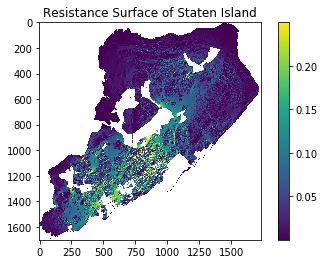

In [75]:
# Mask out zeros present in background using the mask

masked_array = np.ma.masked_inside(p, 0.00, 0.00000000000001)
plt.imshow(masked_array)
plt.title('Resistance Surface of Staten Island')
plt.colorbar()
plt.show()





The white polygons on the map are the regions used as nodes in Circuitscape so they are shown as white because they have very low resistance and high current density. In the future, shapefiles of the node regions will be added for better visualization. 

Generally, the lighter colors are showing areas with high current density where hypothesized movement across the landscape would have less resistance for the animal.

### Adjust the extent of the map
For the dispersal functions, the map needs to be the same number of rows and columns (check this using the numpy.shape argument). This can be acheived it two ways:
* Adding rows/columns of zeros
* Removing rows/columns

Depending on the amount of background surrounding your study area, one of these options may be more appropriate for you. My spatial extent of study area is very restricted already so I added extra rows of zeros. However there is hashed out code to also remove rows if that is preferred. 

In [77]:
# Check shape
p.shape

(1702, 1734)

In [78]:
# Rows and columns must be balanced: We will want shape (1734, 1734) if adding rows 

z = np.zeros((32,1734))
pbal = np.append(p, z, axis = 0)
pbal.shape

# If you prefer to remove excess rows, you can adjust the index code below.

#pbal2 = p[:,0:1702]
#pbal2.shape

(1734, 1734)

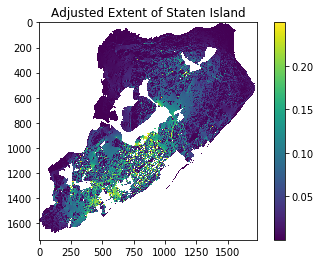

In [50]:
# Check the new map extent
masked_array2 = np.ma.masked_inside(pbal, 0.00, 0.00000000000001)
plt.imshow(masked_array2)
plt.title('Adjusted Extent of Staten Island')
plt.colorbar()
plt.show()

The entire study area is still shown and there is now some excess space on the bottom.

### Saving our new raster file
Here we will save the cleaned up array as a raster .tif file to be imported for notebook 2_Defining_Dispersal. The directory for filename should be adjusted according to your workspace directory. 

Check the datatype and final shape for writing the .tif.

In [85]:
pbal.dtype

dtype('float64')

In [86]:
pbal.shape

(1734, 1734)

In [87]:
# Write new file to the data folder for import in the next notebook
filename = '/Users/meredithvanacker/PDSB/PDSB-Project/data/new_circuit.tif'
x_pixels = 1734  # number of pixels in x
y_pixels = 1734  # number of pixels in y
driver = gdal.GetDriverByName('GTiff')
newdata = driver.Create(filename,x_pixels, y_pixels, 1,gdal.GDT_Float64)
newdata.GetRasterBand(1).WriteArray(pbal)

# The following code is adding GeoTranform and Projection
geotrans=dataset.GetGeoTransform()  #get GeoTranform from original dataset
proj=dataset.GetProjection() #you can get the projection from the existing tif or import a projection
# Write metadata
newdata.SetGeoTransform(geotrans)
newdata.SetProjection(proj)
newdata.FlushCache()
# Close raster file
newdata=None